# The toy classification model

## IMPORTS

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
import torch.nn.functional as F
from matplotlib import colors as colors

Let us generate a toy dataset $(X_i,Y_i)_{i\in[N]}$ iid $\sim (X,Y)$, with
$$
\begin{cases}
X ↪ [-3,3]^2\\
Y = \mathbb{1}\{|X| < 2.4\}
\end{cases}
$$

In [2]:
theoretical_sigma = lambda x:0.15/(1+torch.exp(-x))
theoretical_mu = lambda x:torch.sin(x)

n_samples_train = 2000

x_values_train = torch.rand(n_samples_train,2) * torch.tensor([[3,6]]) + torch.tensor([[0,-3]])
y_values_train = (torch.linalg.vector_norm(x_values_train,dim=1) < 2.4).to(torch.long)

train_dataset = TensorDataset(x_values_train, y_values_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

n_samples_test = 60
subdiv_test = torch.linspace(-6,6,n_samples_test)
x1_test, x2_test = torch.meshgrid(subdiv_test,subdiv_test)

/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


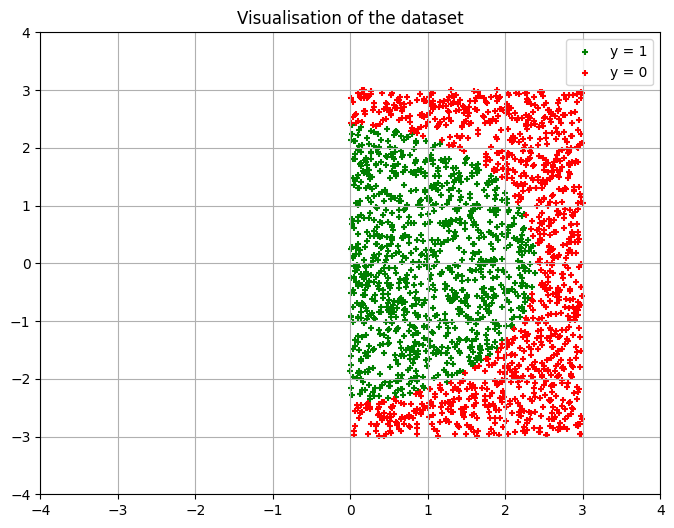

In [3]:
plt.figure(figsize=(8,6))
plt.title("Visualisation of the dataset")

t = torch.linspace(-3,3,100)

index_1 = np.nonzero(torch.linalg.vector_norm(x_values_train,dim=1) < 2.4)
index_0 = np.nonzero(torch.linalg.vector_norm(x_values_train,dim=1) >= 2.4)

plt.scatter(x_values_train[index_1,0],x_values_train[index_1,1],marker="+",s=15,color="green",label="y = 1")
plt.scatter(x_values_train[index_0,0],x_values_train[index_0,1],marker="+",s=15,color="red",label="y = 0")
plt.legend()
plt.grid()
plt.xlim([-4,4])
plt.ylim([-4,4])

plt.show()

## An ensembling model

The objective of this section is to implement uncertainty quantification by *ensembling*. The idea consists in creating $M$ identical NNs, successively training them, and use the logits estimates to predict uncertainty

First, let us create the NN class corresponding to our problem

This NN is composed of two parallel MLPs with 3 layers of width 10. For any $x \in [-3,3]^2$, it outputs the logits of class 0 and class 1

In [4]:
class ToyClassificationModelEnsembling(nn.Module):

  def __init__(self,hidden_size=10,layer_number=3,class_number=2,input_dim=2):

    super().__init__()

    self.mlp = nn.Sequential(
        nn.Linear(2,hidden_size),
        nn.ReLU()
    )

    for i in range(1,layer_number-1):
      self.mlp.append(nn.Linear(hidden_size,hidden_size))
      self.mlp.append(nn.ReLU())

    self.mlp.append(nn.Linear(hidden_size,class_number))

  def forward(self,x):
    return self.mlp(x)



Now, let us train `M` instances of this MLP on our training dataset.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

M = 64
n_epochs = 150
loss_function = nn.CrossEntropyLoss()

nn_list = [ToyClassificationModelEnsembling().to(device) for _ in range(M)]

# training loop

for i in range(M):

  model = nn_list[i]
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  model.train()

  print(f"Starting to train model {i}")

  for e in range(1,n_epochs+1):
    for inputs,targets in train_loader:

      inputs, targets = inputs.to(device),targets.to(device)
      output = nn_list[i](inputs)
      loss = loss_function(output,targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()



Starting to train model 0
Starting to train model 1
Starting to train model 2
Starting to train model 3
Starting to train model 4
Starting to train model 5
Starting to train model 6
Starting to train model 7
Starting to train model 8
Starting to train model 9
Starting to train model 10
Starting to train model 11
Starting to train model 12
Starting to train model 13
Starting to train model 14
Starting to train model 15
Starting to train model 16
Starting to train model 17
Starting to train model 18
Starting to train model 19
Starting to train model 20
Starting to train model 21
Starting to train model 22
Starting to train model 23
Starting to train model 24
Starting to train model 25
Starting to train model 26
Starting to train model 27
Starting to train model 28
Starting to train model 29
Starting to train model 30
Starting to train model 31
Starting to train model 32
Starting to train model 33
Starting to train model 34
Starting to train model 35
Starting to train model 36
Starting to

Now, let us evaluate our prediction on a test dataset : $(X_i)_{i \in [3600]}$ being an uniform subdivision of $[-6,6]^2$.

For each test point $X_i \in \mathbb{R}^2$, we plot the average probability of $x$ belonging to class 1
$$
y(X_i) = \frac{1}{M} \sum_{j=1}^{M} \hat{y}_j(X_i)
$$



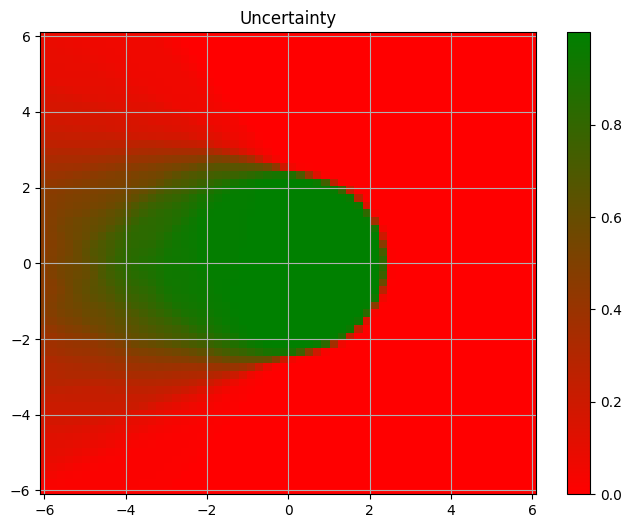

In [6]:
probability_1 = np.zeros((n_samples_test,n_samples_test))

for i in range(n_samples_test):

  probability_1_list = []

  for m in range(M):
    logits = nn_list[m](torch.stack((x1_test[i,:],x2_test[i,:]),axis=-1))
    probability_1_list.append(F.softmax(logits,dim=1).detach().cpu().numpy()[:,1])

  probability_1[i,:] = np.mean(np.stack(probability_1_list,axis=-1),axis=-1)

plt.figure(figsize=(8,6))
plt.title("Uncertainty")

g_r_cmap = colors.LinearSegmentedColormap.from_list("", ["red","green"])
plt.pcolormesh(x1_test.numpy(),x2_test.numpy(),probability_1,cmap=g_r_cmap)
plt.colorbar()

plt.grid()

plt.show()

## A MC-Dropout model

The objective of this section is to implement uncertainty quantification by *MC-Dropout*. The idea consists in creating a few (less than $M$) identical NNs. These NNs contain dropout layers after some of their ReLUs, meaning that the output of the NN is random.

The sequence of probability estimates is generated by running inputs multiple times for each model

Let us create the NN class corresponding to this problem

In [7]:
class ToyClassificationModelDropout(nn.Module):

  def __init__(self,hidden_size=10,layer_number=3,class_number=2,input_dim=2):

    super().__init__()



    self.mlp = nn.Sequential(
        nn.Linear(2,hidden_size),
        nn.ReLU(),
        nn.Dropout(p=0.2)
    )

    for i in range(1,layer_number-1):
      self.mlp.append(nn.Linear(hidden_size,hidden_size))
      self.mlp.append(nn.ReLU())
      self.mlp.append(nn.Dropout(p=0.2))

    self.mlp.append(nn.Linear(hidden_size,class_number))

  def eval_dropout(self):
    for layer in self.mlp:
      if isinstance(layer,nn.Dropout):
        layer.train()

  def forward(self,x):
    return self.mlp(x)



In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

M = 10
n_epochs = 300
loss_function = nn.CrossEntropyLoss()

nn_list_2 = [ToyClassificationModelDropout().to(device) for _ in range(M)]

# training loop

for i in range(M):

  model = nn_list_2[i]
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  model.train()

  print(f"Starting to train model {i}")

  for e in range(1,n_epochs+1):
    for inputs,targets in train_loader:

      inputs, targets = inputs.to(device),targets.to(device)
      output = model(inputs)
      loss = loss_function(output,targets)

      for p in model.parameters():
        if p.requires_grad == True:
          loss += torch.sum(torch.pow(p,2)) * 0.8 / targets.shape[0]

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


Starting to train model 0
Starting to train model 1
Starting to train model 2
Starting to train model 3
Starting to train model 4
Starting to train model 5
Starting to train model 6
Starting to train model 7
Starting to train model 8
Starting to train model 9


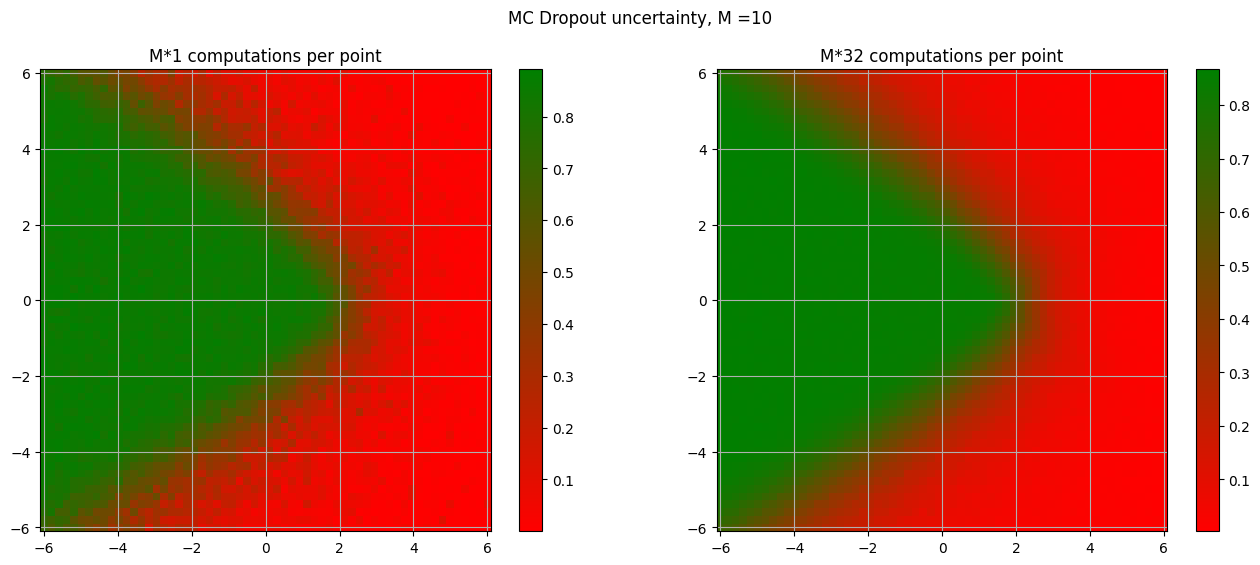

In [9]:
probability_1_1 = np.zeros((n_samples_test,n_samples_test))
probability_1_32 = np.zeros((n_samples_test,n_samples_test))

for i in range(n_samples_test):

  probability_1_list_1 = []
  probability_1_list_32 = []

  for m in range(M):
    nn_list_2[m].eval()
    nn_list_2[m].eval_dropout()
    logits = nn_list_2[m](torch.stack((x1_test[i,:],x2_test[i,:]),axis=-1))
    probability_1_list_1.append(F.softmax(logits,dim=1).detach().cpu().numpy()[:,1])

    for _ in range(32):
      logits = nn_list_2[m](torch.stack((x1_test[i,:],x2_test[i,:]),axis=-1))
      probability_1_list_32.append(F.softmax(logits,dim=1).detach().cpu().numpy()[:,1])

  probability_1_1[i,:] = np.mean(np.stack(probability_1_list_1,axis=-1),axis=-1)
  probability_1_32[i,:] = np.mean(np.stack(probability_1_list_32,axis=-1),axis=-1)


probabilities_1 = [probability_1_1,probability_1_32]
title_list=["M*1 computations per point","M*32 computations per point"]

plt.figure(figsize=(16,6))
plt.suptitle(f"MC Dropout uncertainty, M ={M}")

for i in range(2):

  plt.subplot(1,2,i+1)
  plt.title(title_list[i])
  g_r_cmap = colors.LinearSegmentedColormap.from_list("", ["red","green"])
  plt.pcolormesh(x1_test.numpy(),x2_test.numpy(),probabilities_1[i],cmap=g_r_cmap)
  plt.colorbar()
  plt.grid()

plt.show()
